In [ ]:
# in this version of the pipeline, we include all features--including categorical ones, which have been transformed 
# with pandas' .get_dummies(). this increases the number of features from 17 in pt4 to 977.

In [61]:
import numpy as np
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set_style('whitegrid')
sns.set_context('paper')

In [2]:
def select(query):
    
    conn = sqlite3.connect('./data/lending-club-loan-data/database2.sqlite')
    cursor = conn.cursor()
    temp_df = pd.DataFrame(cursor.execute(query).fetchall())
    temp_df.columns = list(map(lambda x: x[0], cursor.description))
    conn.close()
    
    return temp_df.copy()

In [3]:
features_train = select('select * from final_features_train')
features_test = select('select * from final_features_test')
targets_train = select('select * from final_targets_train').loan_status
targets_test = select('select * from final_targets_test').loan_status

In [4]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

In [5]:
lr = LogisticRegression().fit(features_train,targets_train)

In [6]:
# on baseline evaluation, neg recall is slightly improved when we include categorical information w/ get_dummies !
# recall on minority class is no longer ~ 0 %, it is at about 2%; next, we repeat the whole pipeline. 2% doesn't seem
# significant, but it is orders of magnitude above the previous ~0.01% performance

print(classification_report(targets_test,lr.predict(features_test)))

             precision    recall  f1-score   support

          0       0.42      0.02      0.03      8804
          1       0.83      1.00      0.90     41670

avg / total       0.76      0.82      0.75     50474



In [7]:
# undersampling ratio, SMOTE oversampling ratio, ADASYN oversampling ratio. all 1:1

ratios = [{0:len(features_train[~targets_train.astype(bool)]),\
               1:len(features_train[~targets_train.astype(bool)])},\
         {0:len(features_train[targets_train.astype(bool)]),\
                1:len(features_train[targets_train.astype(bool)])},\
         {0:len(features_train[targets_train.astype(bool)]),\
                1:len(features_train[targets_train.astype(bool)])}]

In [8]:
def Pipeline0(features,targets,model,resample_ratios,metric):
    
    resamplers = [None,RandomUnderSampler,SMOTE,ADASYN]
    resampler_names = ['UnderSamp','SMOTE','ADASYN']
    output = {}
    output['model'] = model[0]
    i = 0
    
    for resampler in resamplers:
        if resampler == None:
            final_features = features.copy()
            final_targets = targets.copy()
            tn,fp,fn,tp = confusion_matrix(targets_test,model[1].fit(final_features,final_targets).predict(features_test)).ravel()
            
            
            output['N_pre'] = tn/(tn+fn)
            output['N_rec'] = tn/(tn+fp)
            
            output['P_pre'] = tp/(tp+fp)
            output['P_rec'] = tp/(tp+fn)
            
        else:
            final_features, final_targets = resampler(ratio=resample_ratios[i]).fit_sample(features,targets)
            tn,fp,fn,tp = confusion_matrix(targets_test,model[1].fit(final_features,final_targets).predict(features_test)).ravel()
            
            
            output[resampler_names[i]+'_N_pre'] = tn/(tn+fn)
            output[resampler_names[i]+'_N_rec'] = tn/(tn+fp)
            
            output[resampler_names[i]+'_P_pre'] = tp/(tp+fp)
            output[resampler_names[i]+'_P_rec'] = tp/(tp+fn)
                
            i+=1
    
    return output

In [9]:
# optimize hyperparameters for F1 score on negative class, since that is the area we're looking to improve

def neg_f1(targets_true,targets_predicted):
    tn, fp, fn, tp = confusion_matrix(targets_true,targets_predicted).ravel()
    precision = tn/(tn+fn)
    recall = tn/(tn+fp)
    return 2*(precision*recall)/(precision+recall)

def pos_f1(targets_true,targets_predicted):
    tn, fp, fn, tp = confusion_matrix(targets_true,targets_predicted).ravel()
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    return 2*(precision*recall)/(precision+recall)

# the metric to optimize for in the regularized runs of the pipeline will determine the appropriate score function

score_dict = {'neg':neg_f1,'pos':pos_f1}

In [10]:
def Pipeline1(features,targets,model,resample_ratios,metric):
    
    resamplers = [None,RandomUnderSampler,SMOTE,ADASYN]
    resampler_names = ['UnderSamp','SMOTE','ADASYN']
    output = {}
    output['model'] = 're'+model[0]
    i = 0
    
    if model[0] == 'LR':
        params = {'C':[.001,.01,.1,1,10,100]}
    elif model[0] == 'GNB': 
        params = {'priors':[[0.1,0.9],[0.2,0.8],[0.3,0.7],[0.4,0.6],[0.5,0.5],[0.6,0.4]]}
    elif model[0] == 'KNN':
        params = {'n_neighbors':list(range(3,8))}
    elif model[0] == 'RF':
        params = {'max_depth':[2,4,8,16,32,100]}
    elif model[0] == 'QDA':
        params = {'priors':[[0.1,0.9],[0.2,0.8],[0.3,0.7],[0.4,0.6],[0.5,0.5],[0.6,0.4]]}
    
    for resampler in resamplers:
        if resampler == None:
            final_features = features.copy()
            final_targets = targets.copy()
            clf = GridSearchCV(model[1],param_grid=params,scoring=make_scorer(score_dict[metric]),return_train_score=True)\
                                .fit(final_features,final_targets)
            tn,fp,fn,tp = confusion_matrix(targets_test,clf.best_estimator_.predict(features_test)).ravel()
            
            
            output['N_pre'] = tn/(tn+fn)
            output['N_rec'] = tn/(tn+fp)
            
            output['P_pre'] = tp/(tp+fp)
            output['P_rec'] = tp/(tp+fn)
            
        else:
            final_features, final_targets = resampler(ratio=resample_ratios[i]).fit_sample(features,targets)
            clf = GridSearchCV(model[1],param_grid=params,scoring=make_scorer(score_dict[metric]),return_train_score=True)\
                                .fit(final_features,final_targets)
            tn,fp,fn,tp = confusion_matrix(targets_test,clf.best_estimator_.predict(features_test)).ravel()
            
            
            output[resampler_names[i]+'_N_pre'] = tn/(tn+fn)
            output[resampler_names[i]+'_N_rec'] = tn/(tn+fp)
            
            output[resampler_names[i]+'_P_pre'] = tp/(tp+fp)
            output[resampler_names[i]+'_P_rec'] = tp/(tp+fn)
                
            i+=1
    
    return output

In [11]:
def PipelineLayer1(model,metric,ratio_dicts):
    unregularized = Pipeline0(features=features_train,targets=targets_train,\
                             model=model,resample_ratios=ratio_dicts,metric=metric)
    
    regularized = Pipeline1(features=features_train,targets=targets_train,\
                            model=model,resample_ratios=ratio_dicts,metric=metric)
    return pd.DataFrame(unregularized,index=[0]).set_index('model')\
                    .append(pd.DataFrame(regularized,index=[0]).set_index('model')).copy()

In [12]:
def PipelineLayer2(model_list,metric,ratios):
    
    tempdf = pd.DataFrame()
    
    for model in model_list:
        tempdf = tempdf.append(PipelineLayer1(model,metric,ratios))
        
    return tempdf.copy()

In [13]:
# we leave out Random Forest -- it takes a random subset of features for each tree, but 900+ features out of 977 (over 90%)
# are dummy variables from the categorical conversion. most of the trees in the ensemble would be built on features that are
# undescriptive. these dummy variables can potentially aid in prediction if they are used together with the main features,
# but have little predictive value on their own.

algs = [('LR',LogisticRegression()),('GNB',GaussianNB()),('KNN',KNeighborsClassifier())]

In [14]:
# cat_results = PipelineLayer2(algs,metric='neg',ratios=ratios)

In [16]:
# ^ computationally infeasible. did not complete after 1.5 hours of computing on a modern cpu (late 2017 model consumer pc)

# reduce categorical columns w PCA, do analysis, and try running again with reduced feature space

# use different unsupervised learning algorithms on the transformed categorical features (dummy variables)
# to find clusters in the categories. (we do not include the original features yet, since their values will reduce 
# the influence of the categorical features which artificially have been given values 0/1 on the dummy variables)
# we will run unsupervised learning algorithms on the original numerical features separately.

# we will make these clusters new features, and use .get_dummies() again and run unsupervised learning algs another time.
# this is an ensemble-approach to unsupervised learning, with the hope that it'll find more complex structure by 
# using information from different clustering approaches. finally, we will run .get_dummies() a last time before 
# inputting the final clusterings to 

In [40]:
# the categorical columns (which have already been transformed to numerical dummies) which we want to reduce w PCA

catcolumns = list(features_train.columns)
catcolumns = catcolumns[11:]

In [46]:
from sklearn.decomposition import PCA

In [84]:
pca = PCA(n_components=20).fit(features_train[catcolumns])

Text(0.5,0,'Components')

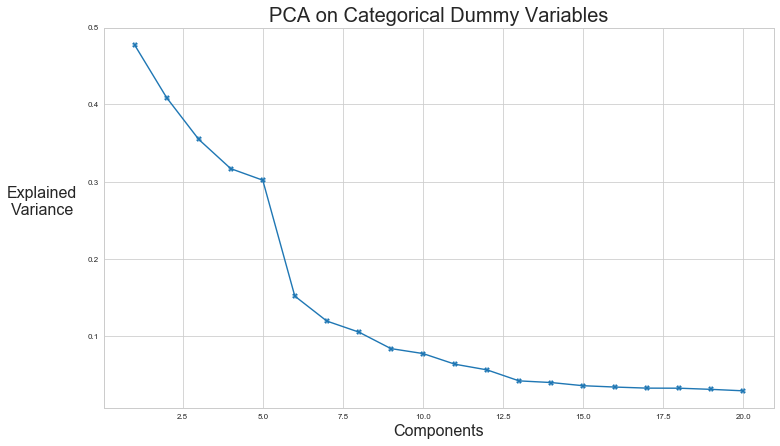

In [88]:
# there is a steep drop in EV on the 6th additional component. visual analysis suggests we project the features onto a 
# 5 dimensional subspace, but EV reduction does not level off until after around 12 dimensions. using 12 dimensions should be
# computationally feasible. we will use 12 so as to not reduce the complexity too much (and risk losing information)

fig, ax = plt.subplots(1,1,figsize=(12,7))

ax.plot(list(range(1,21)),pca.explained_variance_,'X-')
ax.set_title('PCA on Categorical Dummy Variables',fontsize=20)
ax.set_ylabel('Explained\nVariance',fontsize=16,rotation=0,labelpad=45)
ax.set_xlabel('Components',fontsize=16)

In [90]:
pca = PCA(n_components=12).fit(features_train[catcolumns])

In [92]:
# transform represents the categorical dummy features reduced to a 12 dimensional feature space via PCA

transform = pd.DataFrame(pca.transform(features_train[catcolumns]))

In [108]:
numerical = features_train.columns
numerical = numerical[:11]

In [117]:
# the training data, with categorical features reduced to 12 components. now, we have a much more computationally manageable
# feature space dimension of 23. unsupervised learning algorithms can also now be applied (on a baseline test run, k-means
# took too long to finish fitting)

features_train_T = features_train[numerical].merge(transform,left_index=True,right_index=True).copy()

In [174]:
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import AffinityPropagation
from sklearn.metrics import silhouette_score

In [175]:
# not enough memory in RAM to run silhouette score on the full training set.. we will compute 
# silhouette score on a random sample. computing the silhouette score is fairly computationally expensive.. saving
# results to eliminate need for re-running that bit of code

ss = []
#sil_avgs = []

for n in range(2,31):
    KM = KMeans(n_clusters=n,random_state=2).fit(features_train_T[list(range(12))])
    ss.append(KM.inertia_)
    
    #labeled_features = features_train_T[list(range(12))].merge(pd.DataFrame(KM.labels_),\
                                                               #left_index=True,right_index=True).copy()
    #sil_avgs.append(silhouette_score(labeled_features.sample(30000,random_state=2).drop('0_y',axis=1),\
                 #labeled_features.sample(30000,random_state=2)['0_y']))

In [198]:
#pd.DataFrame(sil_avgs).to_csv('./data/category-silhouette-avgs.csv')

sil_avgs = list(pd.read_csv('./data/category-silhouette-avgs.csv').drop('Unnamed: 0',axis=1)['0'])

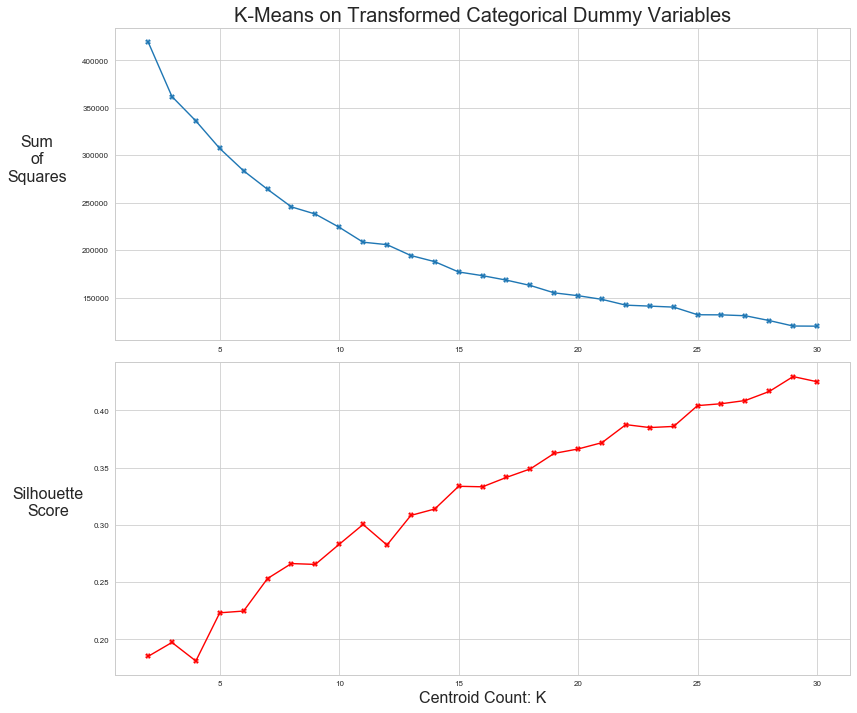

In [200]:
# there is not a very obvious choice for k using analysis of sum of squares reduction -- SoS seems to continue to decrease
# without leveling off even after 30 centroids are used. silhouette score is equally difficult to use to conclude an
# optimal number of clusters--it seems to keep increasing (though not monotonically) with the cluster count

fig, (ax1,ax2) = plt.subplots(2,1,figsize=(12,10))

ax1.plot(list(range(2,31)),ss,'X-')
ax1.set_title('K-Means on Transformed Categorical Dummy Variables',fontsize=20)
ax1.set_ylabel('Sum\nof\nSquares',fontsize=16,rotation=0,labelpad=45)

ax2.plot(list(range(2,31)),sil_avgs,'Xr-')
ax2.set_ylabel('Silhouette\nScore',fontsize=16,rotation=0,labelpad=45)
ax2.set_xlabel('Centroid Count: K',fontsize=16)

plt.tight_layout()